# General Setup

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import re
import glob
import operator
from pathlib import Path

import compress_pickle as pickle
import imageio.v3 as iio
import ipywidgets

from quantaodometry.homography import *
from quantaodometry.panorama import *
from quantaodometry.dataset import *
from quantaodometry.color import *
from quantaodometry.utils import *

pkl_ext = ".pkl.lzma"

In [3]:
# !pip install -U imageio ipywidgets networkx shapely torch torchgeometry torchvision matplotlib scipy more_itertools tqdm compress_pickle opencv-python sqlitedict natsort

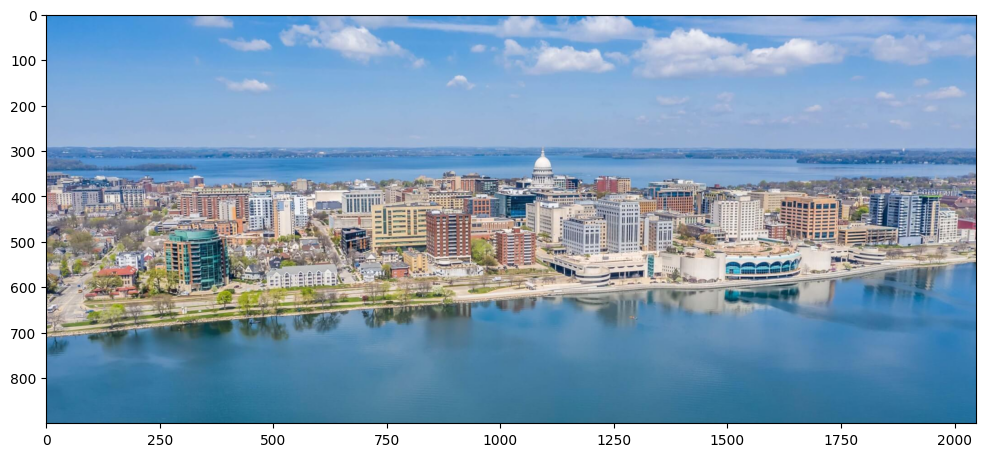

In [4]:
# Load image which we'll create panorama from
try:
    img = iio.imread("imgs/madison-panorama.jpg")
except FileNotFoundError:
    img = imageio.imread(
        "https://www.cleanlakesalliance.org/wp-content/uploads/2021/06/Madison-Skyline-Robert-Bertera-scaled.jpg"
    )
    iio.imsave("imgs/madison-panorama.jpg", img)

# Crop it a little and turn it into a torch tensor
img_path = Path("imgs/madison-panorama.jpg")
img = iio.imread(img_path)[200:1100, :, :]

img = img_to_tensor(img / 255)[0]
plt.figure(figsize=(12, 8))
plt.imshow(tensor_to_img(img))

In [5]:
# Define constants
device = "cuda:0"
*_, img_h, img_w = img.shape
crop_h, crop_w, *_ = crop_size = (480, 640, 3)

# Create Panorama frames from GT image

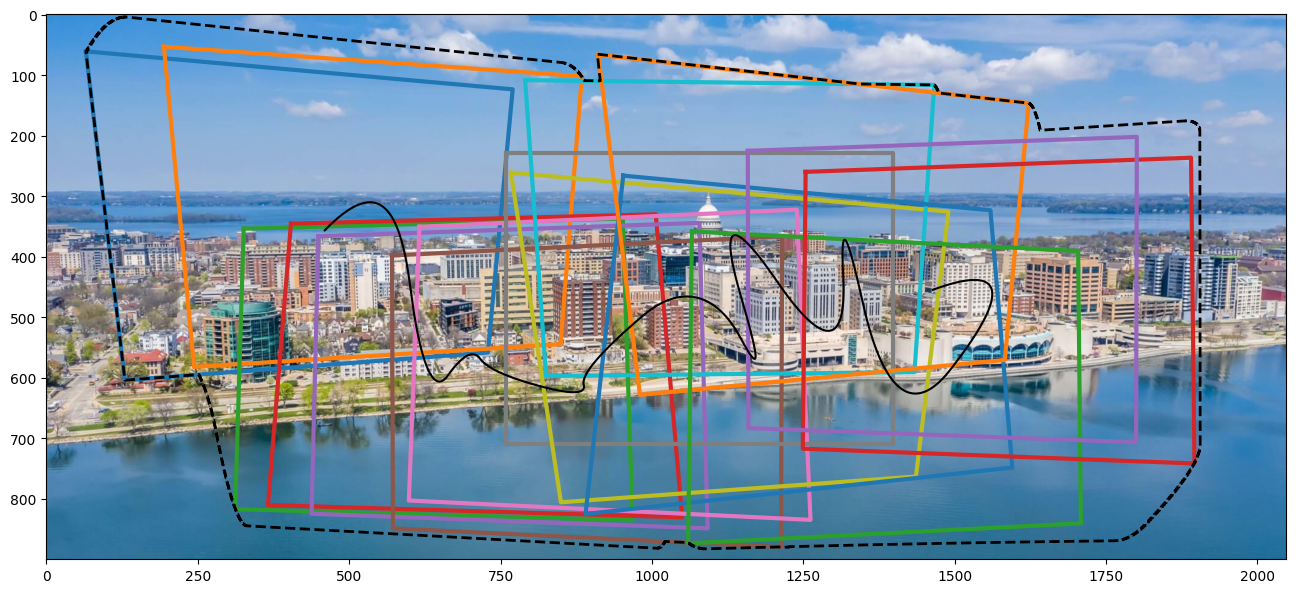

In [6]:
# Generate some homagraphies and display them on the image
plt.figure(figsize=(16, 12))
plt.imshow(tensor_to_img(img))

np.random.seed(0)
kps = list(
    zip(
        np.linspace(450, 1550, 15) + np.random.uniform(low=-100, high=100, size=15),
        np.random.uniform(low=330, high=630, size=15),
    )
)
kp_hs = [
    translation_matrix(x, y)
    @ homography_from_params(
        0.5 * np.random.normal(loc=0, size=8) / np.sqrt(img_h**2 + img_w**2)
        if i != len(kps) // 2
        else np.zeros(8),
        mode="lk",
    )
    @ translation_matrix(-crop_w / 2, -crop_h / 2)
    for i, (x, y) in enumerate(kps)
]
gt_interp_hs = homography_interp(
    kp_hs, np.linspace(0, 1, len(kps)), mode="lk", interp_kind="quadratic"
)
hs = gt_interp_hs(np.linspace(0, 1, 10_000))
wrt_t = (len(kps) // 2) / (len(kps) - 1)

for h in kp_hs:
    corners = get_corners(h, crop_size)
    plt.plot(*corners[[0, 1, 2, 3, 0]].T, lw=3)

outline = outline_from_homographies(hs[::10], crop_size)
plt.plot(*outline, lw=2, c="k", ls="--")

points = torch.cat([warp_points(h, [crop_w / 2, crop_h / 2]) for h in hs]).squeeze()
plt.plot(*points.T, c="k")

# View generated frames

In [7]:
# Visualize all types of patches

# UI elements
location_widget = ipywidgets.FloatSlider(
    min=0.0, max=1.0, step=0.01, value=0.5, description="t"
)
postmerge_widget = ipywidgets.Checkbox(value=True, description="Post-Merge Transform")
height_widget = ipywidgets.IntSlider(
    min=10, max=1000, step=1, value=crop_h, description="Height"
)
width_widget = ipywidgets.IntSlider(
    min=10, max=1000, step=1, value=crop_w, description="Width"
)

factor_widget = ipywidgets.FloatSlider(
    min=0.01, max=2.0, step=0.01, value=1.0, description="Factor"
)
burst_size_widget = ipywidgets.IntSlider(
    min=1, max=200, step=1, value=1, description="Burst Size"
)
fwc_widget = ipywidgets.IntSlider(
    min=10, max=1000, step=1, value=500, description="FWC"
)
readout_std_widget = ipywidgets.IntSlider(
    min=0, max=100, step=1, value=20, description="Read Noise"
)

inputs_widget = ipywidgets.VBox(
    [
        ipywidgets.HBox([burst_size_widget, factor_widget]),
        ipywidgets.HBox([fwc_widget, readout_std_widget]),
    ]
)

frame_types = {
    "Ground Truth": {"class": Patches, "widgets": []},
    "Binary Frame": {
        "class": BinaryPatches,
        "widgets": [burst_size_widget, factor_widget],
        "kwargs": dict(factor=factor_widget),
    },
    "RGB Frame": {
        "class": RGBPatches,
        "widgets": [burst_size_widget, factor_widget, fwc_widget, readout_std_widget],
        "kwargs": dict(
            burst_size=burst_size_widget,
            factor=factor_widget,
            readout_std=readout_std_widget,
            fwc=fwc_widget,
        ),
    },
}

types_widget = ipywidgets.Dropdown(
    options=frame_types.keys(), index=0, description="Frame Type"
)


def update_inputs(*args):
    def all_children(node):
        if getattr(node, "children", None):
            return list(mitertools.flatten((all_children(c) for c in node.children)))
        return [node]

    for child in all_children(inputs_widget):
        child.layout.display = ["none", None][
            int(child in frame_types[types_widget.value]["widgets"])
        ]


types_widget.observe(update_inputs, "value")
update_inputs()


def show_frames(
    frame_type,
    location,
    burst_size,
    postmerge=True,
    h=crop_h,
    w=crop_w,
    total_n=10_000,
    **kwargs,
):
    plt.figure(figsize=(16, 8))

    if burst_size == 1:
        burst_idxs = np.array([location])
    else:
        burst_idxs = np.linspace(
            location - burst_size / (2 * total_n),
            location + burst_size / (2 * total_n),
            burst_size,
        )
        burst_idxs = burst_idxs[(burst_idxs >= 0.0) & (burst_idxs <= 1.0)]

    if len(burst_idxs) != burst_size:
        print(
            f"WARNING: Burst size was truncated to {len(burst_idxs)}. Reduce the size of the burst window or shift it's location."
        )

    # We need to shift the warps if viewing a patch smaller of size != crop_size to ensure the center stays fixed
    shifted_hs = [
        to_numpy(translation_matrix(-w / 2 + crop_w / 2, -h / 2 + crop_h / 2)) @ h_
        for h_ in gt_interp_hs(burst_idxs)
    ]
    kwargs = {k: v.value for k, v in frame_types[frame_type].get("kwargs", {}).items()}
    patches = frame_types[frame_type]["class"](
        img.to(device), shifted_hs, (h, w, 3), **kwargs, device=device
    )
    patch = functools.reduce(
        operator.add, (patches[i] for i in range(len(burst_idxs)))
    ) / len(burst_idxs)
    patch = (
        patches.post_merge_transform(patch, burst_size=len(burst_idxs))
        if postmerge
        else patch
    )
    plt.imshow(tensor_to_img(patch * 255))


menu = ipywidgets.VBox(
    [
        ipywidgets.HBox([types_widget, location_widget, postmerge_widget]),
        ipywidgets.HBox([height_widget, width_widget]),
        inputs_widget,
    ]
)

# Pass all widgets so that they all trigger a refresh
out = ipywidgets.interactive_output(
    show_frames,
    dict(
        frame_type=types_widget,
        location=location_widget,
        burst_size=burst_size_widget,
        postmerge=postmerge_widget,
        factor=factor_widget,
        h=height_widget,
        w=width_widget,
        readout_std=readout_std_widget,
        fwc=fwc_widget,
    ),
)

display(ipywidgets.VBox([menu, out]))

# Reconstruct Panorama

### Ground Truth Panorama

In [8]:
path = f"figs/panos/{img_path.stem}/gt-rgb.png"
Path(path).parent.mkdir(parents=True, exist_ok=True)

  0%|          | 0/100 [00:00<?, ?it/s]

/afs/cs.wisc.edu/u/s/j/sjungerman/Research/QuantaOdometry/src/quantaodometry/utils.py:60: RuntimeWarning: invalid value encountered in cast
  imgs = [np.clip(i, 0, 255).astype(np.uint8) if np.nanmax(i) > 1.0 else i.astype(float) for i in imgs]


Panorama()

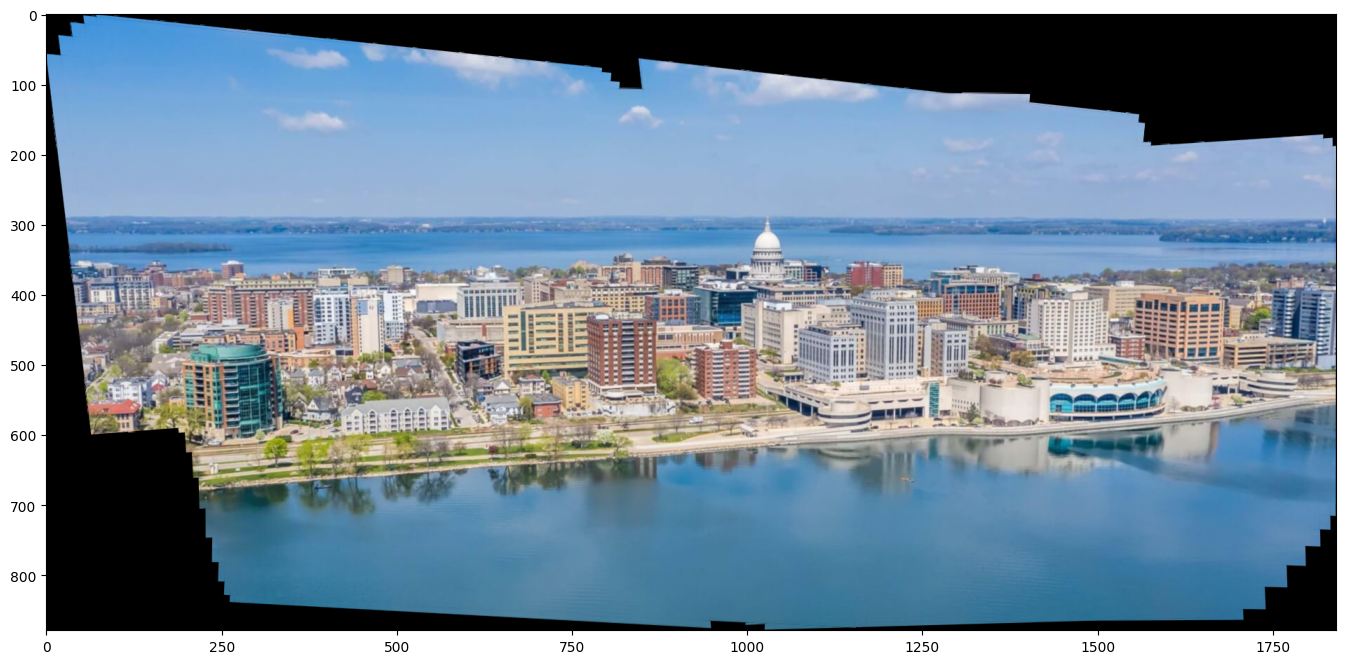

In [9]:
# Instantiate the Pathces dataset which enables loading warped GT images
# Don't use too many gt-rgb frames to assemble gt panorama, only use ~100 (just saves time)
t = np.linspace(0, 1, 100)
patches = Patches(img, gt_interp_hs(t), crop_size)

# Create panorama building object and add frames to it
# Here the frames are added using shifted homographies which removes unneccesary padding
# We use add_frames because we know their homographies already.
pano = Panorama(crop_size, device=device)
interp_hs = homography_interp(
    [LA.inv(h) @ translation_matrix(outline.min(axis=1)) for h in patches.hs],
    t,
    mode="lk",
)
shape, offset = pano.add_frames(
    interp_hs(t), patches, shapes=itertools.repeat(crop_size, len(t))
)
iio.imwrite(path, pano.as_image())

# Save a bunch of extra data which will help when plotting
with Path(path).with_suffix(pkl_ext).open("wb") as f:
    pickle.dump(
        (
            (1, False),
            pano.to("cpu"),
            offset.to("cpu"),
            interp_hs,
            t * len(t),
            len(patches),
            gt_interp_hs,
            wrt_t,
        ),
        f,
    )

pano

### RGB Frame Panorama

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Panorama()

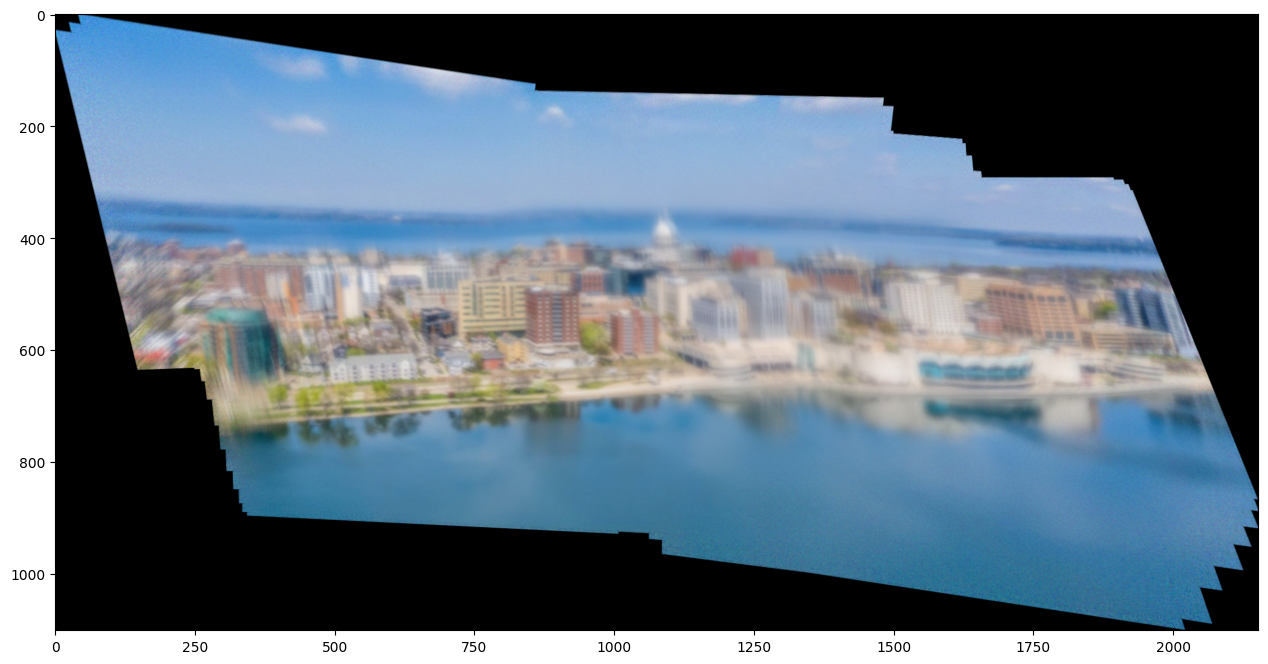

In [10]:
# We simulate realistic RGB frames (with motion blur, quantization, and noise) and create a panorama using those
# Here the panorama constructor `construct` is used. It estimated homographies of pairwise frames using SIFT features + RANSAC by default.
bs = 100
factor = 1.0

patches = RGBPatches(
    img.to(device),
    hs,
    crop_size,
    burst_size=bs,
    fwc=500,
    readout_std=0,
    factor=factor,
    device=device,
)
(
    (lvl, interp_last),
    pano,
    offset,
    merged_patches,
    interp_hs,
    center_idxs,
) = Panorama.construct(
    patches, levels=0, device=device, burst_size=bs, wrt=0.5, num_workers=0, full=True
)
path = f"figs/panos/{img_path.stem}/rgb-lvl{lvl-int(not interp_last)}-bs{bs:04}-factor1k{round(factor*1000):04}.png"
iio.imwrite(path, pano.as_image())

with Path(path).with_suffix(pkl_ext).open("wb") as f:
    pickle.dump(
        (
            (lvl, interp_last),
            pano.to("cpu"),
            offset.to("cpu"),
            interp_hs,
            center_idxs,
            len(patches),
            gt_interp_hs,
            wrt_t,
        ),
        f,
    )

pano

### Quanta Frame Panorama

In [11]:
# Create panoramas from binary frames of varying light levels

# Running all light levels takes a while...
# factors = [0.05, 0.1, 0.5, 1.0]
factors = [1.0]

for bs, factor in itertools.product([100], factors):
    # Create dataset of binary frames sampled from img with homographies `hs`.
    # The factor argument is a relative light-level. Factor of 1 corresponds to the same lighting as GT.
    patches = BinaryPatches(img.to(device), hs, crop_size, factor=factor, device=device)

    try:
        # Construct panoramas from binary frames and save their state at each level (of iterated refinement)
        # For each level there's two progress bars, one for estimating warps, the other to assemble the pano.
        for pano_data in Panorama.multi_construct(
            patches,
            levels=range(4),
            device=device,
            burst_size=bs,
            wrt=0.5,
            num_workers=0,
            full=True,
        ):
            (
                (lvl, interp_last),
                pano,
                offset,
                merged_patches,
                interp_hs,
                center_idxs,
            ) = pano_data
            print(
                f"Saving panorama (level={lvl-int(not interp_last)}, factor={factor})"
            )

            path = f"figs/panos/{img_path.stem}/binary-lvl{lvl-int(not interp_last)}-bs{bs:04}-factor1k{round(factor*1000):04}.png"
            iio.imwrite(path, pano.as_image())

            with Path(path).with_suffix(pkl_ext).open("wb") as f:
                pickle.dump(
                    (
                        (lvl, interp_last),
                        pano.to("cpu"),
                        offset.to("cpu"),
                        interp_hs,
                        center_idxs,
                        len(patches),
                        gt_interp_hs,
                        wrt_t,
                    ),
                    f,
                )

            print("Wrote", path)
    except Exception as e:
        print(e, bs, factor)

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Saving panorama (level=0, factor=1.0)
Wrote figs/panos/madison-panorama/binary-lvl0-bs0100-factor1k1000.png


  0%|          | 0/10000 [00:00<?, ?it/s]

Saving panorama (level=1, factor=1.0)
Wrote figs/panos/madison-panorama/binary-lvl1-bs0100-factor1k1000.png


  0%|          | 0/199 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Saving panorama (level=2, factor=1.0)
Wrote figs/panos/madison-panorama/binary-lvl2-bs0100-factor1k1000.png


  0%|          | 0/397 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Saving panorama (level=3, factor=1.0)
Wrote figs/panos/madison-panorama/binary-lvl3-bs0100-factor1k1000.png


Panorama()

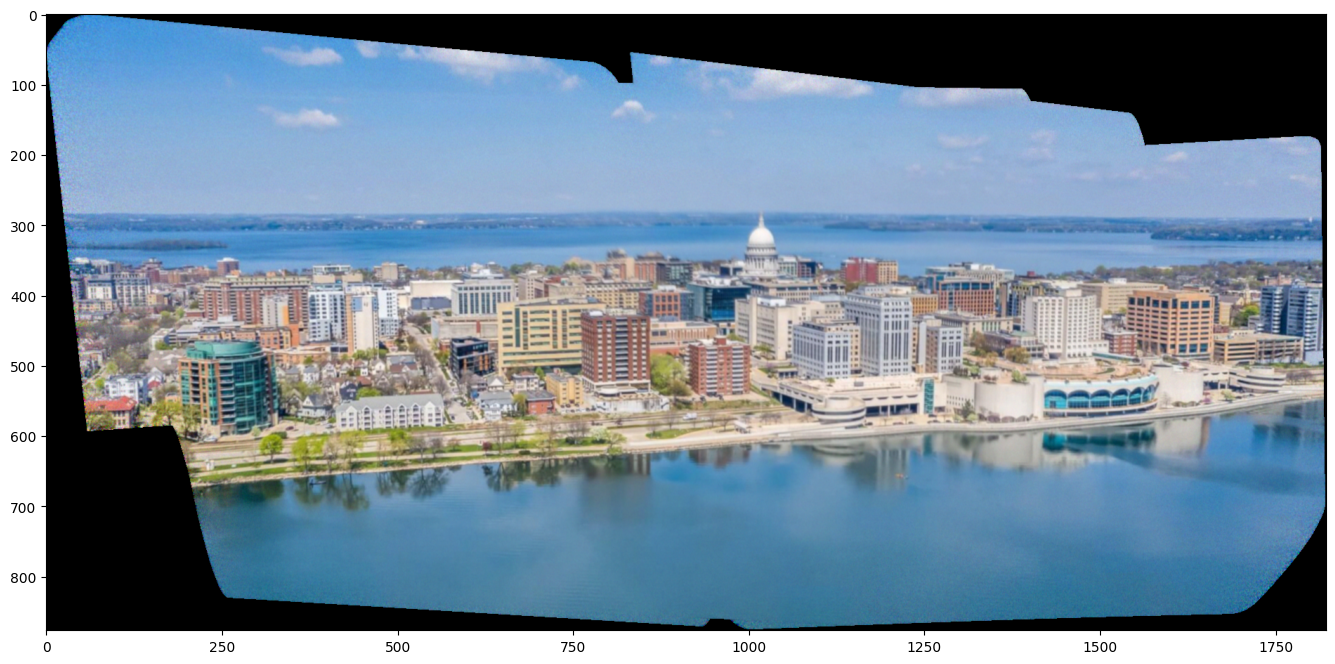

In [12]:
# Display last pano
pano

# Display Results

In [13]:
# View results
paths = glob.glob(f"figs/panos/{img_path.stem}/*gt*{pkl_ext}") + sorted(
    glob.glob(f"figs/panos/{img_path.stem}/*binary*{pkl_ext}")
)


@ipywidgets.interact_manual(t=(0.0, 1.0, 0.001), h=(10, 1000), w=(10, 1000))
def show(t=0.5, w=200, h=200, spline=True, gt_spline=True, outline=True, padd=100):
    fig = plt.figure(figsize=(12, len(paths) * 8), tight_layout=True)
    grid = fig.add_gridspec(len(paths), 2, width_ratios=[3, 1])

    for i, path in enumerate(paths):
        print(f"Loading from {path}...")

        with open(path, "rb") as f:
            (
                (lvl, interp_last),
                pano,
                offset,
                interp_hs,
                center_idxs,
                n,
                gt_interp_hs,
                wrt_t,
            ) = pickle.load(f)
            pano_img = pano.as_image()

            # Estimate shift between GT panorama and estimated one based on location of wrt's frame location
            shift = (
                warp_points(LA.inv(gt_interp_hs(wrt_t)), [0, 0])
                + warp_points(LA.inv(interp_hs(wrt_t)), [0, 0])
                - offset
            )

        ax1 = fig.add_subplot(grid[i, 0])
        axes_img = ax1.imshow(pano_img)

        if spline:
            points = torch.cat(
                [
                    warp_points(
                        to_numpy(translation_matrix(-offset)) @ LA.inv(interp_hs(t_)),
                        [crop_w / 2, crop_h / 2],
                    )
                    for t_ in center_idxs / (n - 1)
                ]
            )
            ax1.plot(*points.squeeze().T, lw=1, c="r")
            ax1.scatter(*points.squeeze().T, c="r", s=3)

        if gt_spline:
            points = torch.cat(
                [
                    warp_points(
                        to_numpy(translation_matrix(shift)) @ h,
                        [crop_w / 2, crop_h / 2],
                    )
                    for h in gt_interp_hs(np.linspace(0, 1, 1000))
                ]
            )
            ax1.plot(*points.squeeze().T, lw=2, c="k")

        if outline:
            outline_ = (
                outline_from_homographies(
                    gt_interp_hs(np.linspace(0, 1, 1000)), crop_size
                )
                + shift.T.numpy()
            )
            (min_x, min_y), (max_x, max_y) = (
                outline_.min(axis=1) - padd,
                outline_.max(axis=1) + padd,
            )
            ax1.plot(*outline_, lw=2, c="w", ls="--")
            ax1.set_xlim(min_x, max_x)
            ax1.set_ylim(max_y, min_y)

        center = warp_points(
            to_numpy(translation_matrix(-offset)) @ LA.inv(interp_hs(t)),
            [crop_w / 2, crop_h / 2],
        ).squeeze()
        corners = get_corners(translation_matrix(center), (h, w), centered=True).numpy()
        ax1.plot(*corners[[0, 1, 2, 3, 0]].T, lw=2, c="r")
        ax1.get_xaxis().set_ticks([])
        ax1.get_yaxis().set_ticks([])
        ax1.set_ylabel(Path(path).stem)
        ax1.set_facecolor("black")

        ax2 = fig.add_subplot(grid[i, 1])
        (start_w, start_h), (end_w, end_h) = np.floor(corners.min(axis=0)).astype(
            int
        ), np.ceil(corners.max(axis=0)).astype(int)
        ax2.imshow(pano_img[start_h:end_h, start_w:end_w])
        ax2.get_xaxis().set_ticks([])
        ax2.get_yaxis().set_ticks([])

        plt.savefig("pano-comparison.png")

interactive(children=(FloatSlider(value=0.5, description='t', max=1.0, step=0.001), IntSlider(value=200, descr…